# Crosshole Seismic Tomography

This is a notebook demonstrating crosshole traveltime tomography. It is indented as a simple demonstration where we **ignore Snell's law**, to simplify the computations greatly. The traveltime of a ray between a transmitter and a receiver can be written as

$$
t(ray) = \int_{ray} s(x,y) \: dl
$$
where $t$ is the total travel time and $s(x, y)$ is the slowness at coordinates $(x,y)$, see Bording et al. (1987). Ignoring Snell's law, the rays can be modelled as stright lines. This circumvents the nonlinearity in the problem, but it is still generally underdetermined and highly ill-posed.

If we discretize the equation, for example with some rectangular grid with $N$ cells, we get
$$
\hat{t}(ray) = \sum_{i=1}^N \hat{s}_i d_i
$$
where $\hat{t}$ is the approximate travel time, and $\hat{s}_i$ and $d_i$ is the slowness and distance tavelled at cell $i$, repectively.

In matrix form, we get
$$
\mathbf{t} = \mathbf{D} \: \mathbf{s}
$$
where $\mathbf{D}$ is a matrix with elements $d_{ij}$ representing the distance ray $i$ travels in cell $j$. The matrix $\mathbf{D}^T\mathbf{D}$ is generally singular, so we have to use some kind of regularisation to solve the inverse problem.


Bording, R. P., Gersztenkorn, A., Lines, L. R., Scales, J. A., & Treitel, S. (1987). Applications of seismic travel-time tomography. Geophysical Journal International, 90(2), 285–303. https://doi.org/10.1111/j.1365-246X.1987.tb00728.x


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from traveltime import TravelTime
from random_process import *

In [2]:
# set up a mesh
my_mesh = {'extent': (-1, 1, -4, 0), 'resolution': (20, 40)}

# set the sensor depths.
my_sensor_depths = np.linspace(-0.2, -3.8, 13)

# set the slowness parameters.
my_slowness = {'kernel': ARD_Squared, 'lambda': (0.7, 0.2), 'mkl': 128, 'mean': 0.0, 'stdev': 1.0}

# create an instance and assemble the distance matrix.
tt = TravelTime(my_mesh, my_sensor_depths, my_slowness)
tt.assemble()

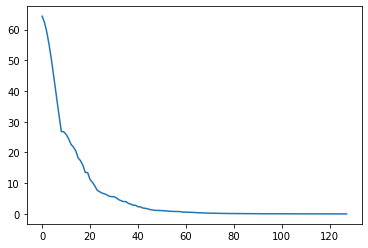

In [3]:
# Make sure that the slowness model eigenvalues decay to zero.
plt.plot(tt.slowness.eigenvalues)
plt.show()

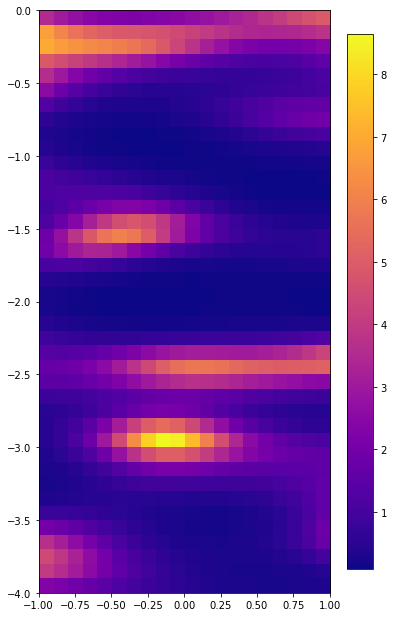

In [4]:
# generate some random parameters and solve the model with them.
np.random.seed(123)
pars = np.random.normal(size=my_slowness['mkl'])
tt.solve(pars)

tt.plot_slowness(plot_rays=False)

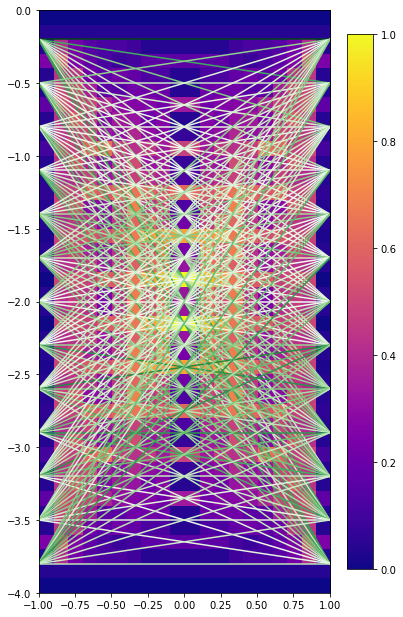

In [5]:
# plot the coverage and the rays.
tt.plot_coverage(plot_rays=True)

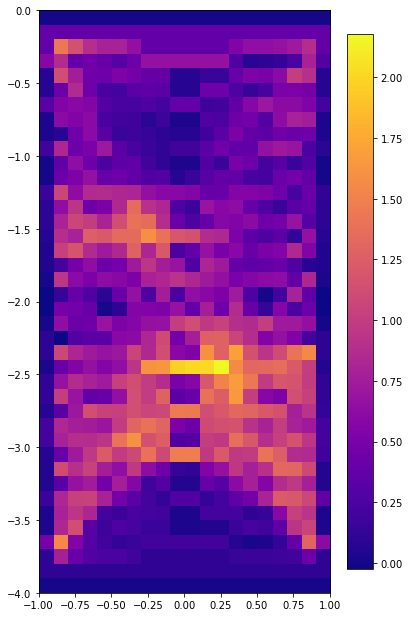

In [6]:
# try to invert using lambda=1 (not very good! regularisation is too strong.)
my_lamb = 1
tt.invert(my_lamb)
tt.plot_slowness(inverse=True)

In [7]:
# here, we try a bunch of values for lambda, from 10 to 10^-9.
# set up an empty list for the errors.
e = []

# set the lambdas, that we are going to test.
lamb = np.logspace(1, -9, 100)

# iterate through the lambdas, invert and collect the errors.
for l in lamb:
    tt.invert(l)
    e.append(tt.s_inv - tt.s)
    
# compute the squared norm of the errors (rho).
e = np.array(e)
rho = np.linalg.norm(e, axis=1)**2

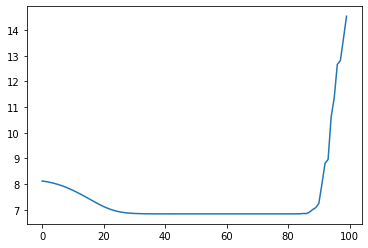

In [8]:
# plot all log-rho.
plt.plot(np.log(rho))
plt.show()

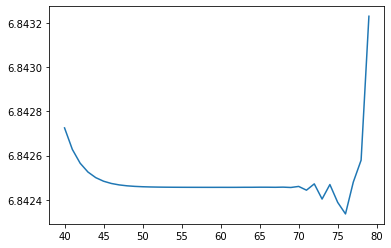

In [9]:
# choose a subset of log-rho, to try and identify knee.
start = 40; end = 80
plt.plot(np.arange(start,end), np.log(rho)[start:end])
plt.show()

In [10]:
# pick an index
my_lambda = lamb[50]
print('Best lambda: {}'.format(my_lambda))

Best lambda: 8.902150854450393e-05


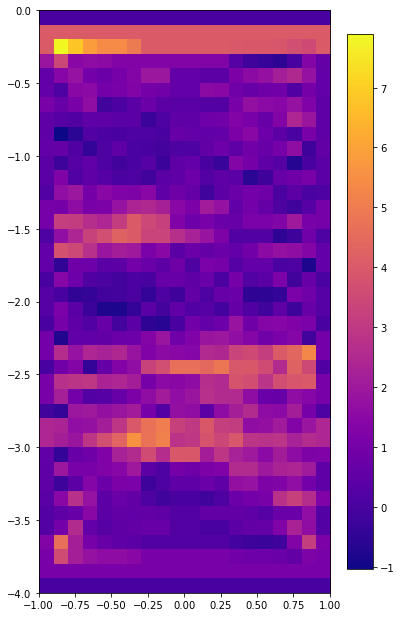

In [11]:
# invert using the optimal lambda.
tt.invert(my_lambda)
tt.plot_slowness(inverse=True)